# Cell population simulation: wild type has growth advantage over mutant

Summary of code:
1) Define cell object to record 

    - self index
    - index of parent
    - birth time
    - plasmid count at birth
    - steady state plasmid count
    - division time (dependent on existence of plasmids) <p>&nbsp;</p>
    
2) Simulate population starting with "keep" number of cells at time 0 with a nonzero number of plasmids and uniformly distributed ages

    - Calculate steady state plasmid number. **Assume that plasmid distribution reaches steady state before division**. 
        + If initial plasmid count is 0, steady state plasmid count is 0
        + If initial plasmid count > 0, steady state plasmid count is sampled from the distribution Binom([max plasmid number n], 0.5)
            *Question: This means that a cell can lose plasmids entirely - should I choose a different distribution? <p>&nbsp;</p>
        
    - Partition plasmids to two daughter cells.
        + Number of plasmids in daughter 1: sample from Binom([steady state plasmid number], 0.5)
        + Number of plasmids in daughter 2: [steady state plasmid number]-[daughter 1 plasmid number] <p>&nbsp;</p>
    
    - Create two new daughter cells.
        + Birth times are the current cell's division time
        + Division time is [birth time] + a_m if they have 0 plasmids, and [birth time] + a_w if they have more than 0 plasmids <p>&nbsp;</p>

    - Remove current cell from queue of cells to process; add daughter cells. Sort the queue by division time so that the next cell to divide is processed in the next loop <p>&nbsp;</p>

3) I store all cells that have already divided in a list called "cells", and I store all cells in the queue, aka the currently alive population, in a list called "Q". 
    



In [1]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt

In [25]:
class cell:
    def __init__(self,index,parent,birth,init_plasmid,tau):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        return:: None
        '''
        self.index=index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+tau

In [66]:
def simulation(Nmax, keep, a_w, a_m, n, p):
    
    init_plasmid=1 #initial plasmid number of first cell. Arbitrary- just can't be 0
    #c= cell(0,[],0,init_plasmid,a_w)   #cell(index,parent,birth,initialplasmid,tau)
    
    Q=[] # initialize queue of cells that have not divided yet (currently alive cells)
    for i in range(keep):
        Q.append(cell(i, [], 0, init_plasmid, np.random.uniform(0,a_w))) #cell(index,parent,birth,initialplasmid,tau)
        #note: division time = birth + tau. 
        #I initialize cells so they will divide at some point between 0 and a_w time units in the future
        #so for the initialized cells, their age at the begining of the simulation is a_w - Q[i].div
   
    cells=[] #list of cells that have divided already
    N=keep-1 #indices taken by initialized cell population
    count=0
    while len(cells)<Nmax:
        #sort Q so Q[0] is next cell to divide
        Q=sorted(Q,key=lambda x: x.div, reverse=False)
        
        #assign current cell to simulate
        current=Q[0]

        #Calculate steady state plasmid number
        if current.init_plasmid==0:
            ss_plasmid_num=0
        else:
            ss_plasmid_num=np.random.binomial(n,p,size=None)
        current.ss_plasmid=ss_plasmid_num

        #Partition plasmids between two daughter cells
        d1_plasmids=np.random.binomial(ss_plasmid_num,p,size=None)
        d2_plasmids=ss_plasmid_num-d1_plasmids

        #Create two new daughter cells
        if d1_plasmids==0:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
        if d2_plasmids==0:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
    
        #Add current cell to vector 'cells'
        cells.extend([current])
    
        #####To keep cell population at a fixed number by removing one cell after each division
        ##### once the population reaches a certain size, include this section:
        
        if len(Q)>=keep:
            rem_cells = rand.sample(Q[1:],1)  #cells to be removed (does not include current or daughters)  
            new_Q = [x for x in Q if x not in rem_cells]
            Q = new_Q.copy()
        
        ########


        #Update index for next time
        N+=2

        #Update Q for next time - remove current cell, add daughter cells
        Q.remove(current)
        Q.extend([daughter1,daughter2])
        count=count+1
        
    return Q, cells, count

In [67]:
Nmax=200 #number of cells processed by simulation
keep=100
a_w=1 #wild type mean lifetime (note: the population with the shorter lifetime has the advantage)
a_m=2 #0 plasmid mean lifetime
n=20 #max number of plasmids
p=.5 #probability of success in binomial distribution; used to calculate steady state plasmid num and also 
     #daughter plasmid partitioning


(array([ 1.,  5.,  7.,  6., 21., 21., 19., 11.,  5.,  3.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 20 artists>)

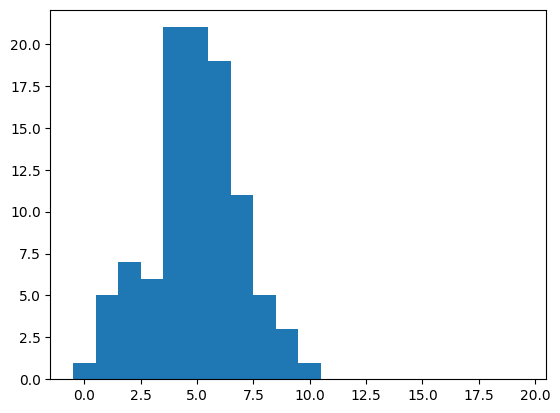

In [68]:
Q, cells, count = simulation(Nmax, keep, a_w, a_m, n, p)
Q_init=[]
for i in Q:
    Q_init.extend([i.init_plasmid])
plt.hist(Q_init,bins=n, range=[-.5,19.5])


In [69]:
for i in range(len(cells)):
    print(cells[i].div)

print(len(cells))
print(count)

0.005116676081701743
0.008565621254037703
0.011570035186149297
0.015474661567262293
0.02317831550907412
0.027569934673483787
0.031984669079352934
0.04090605429044425
0.04112381680055743
0.051809754371110905
0.12113353842496621
0.16996810334245183
0.17686686989915423
0.18499137035675361
0.2143197520348631
0.21754435388518134
0.27111094491122334
0.2762778368137325
0.28053914928149437
0.3034044216733943
0.3112869539403078
0.32428877427627
0.3251778306430334
0.3314145453917393
0.35395514143875073
0.36841883225709515
0.37407565943987775
0.38713790808673
0.4137216995759949
0.4251658801149846
0.42534806187138385
0.42655600318611553
0.43838352367136424
0.4535807044433907
0.4647326813447529
0.4808469397579198
0.4991172658776486
0.5057241479359073
0.5070500308679223
0.5237955218945369
0.5733538032820686
0.5804477059127653
0.5862524096612232
0.6115503885492817
0.6234582842974161
0.6337632280043566
0.6508546654821823
0.6639164843230948
0.6671634278311761
0.6770369235331408
0.706356974847557
0.7162

In [61]:
for i in range(len(Q)):
    print(Q[i].index)

print(len(Q))

79
16
38
85
2
98
45
53
64
95
19
55
23
41
14
48
92
89
94
54
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
180
